# Exploratory Data Analysis of Blood Pressure GWAS Variants
- Annotations collected via Hail in the Google Cloud Platform to then enter this EDA script
- Missingness, relationship to dependent variable, and correlation between features visualised

- Many variant annotations have missing values and so during the Hail annotation had missing values replace with zeros (to avoid imputing bias values but still using the small about of true values present in those annotations) - I am not sure about the reliability of this approach.

In [1]:
# import libraries:

import re
import time
import warnings

import matplotlib.pylab as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from pulearn import BaggingPuClassifier, ElkanotoPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

seed = 42

In [2]:
pd_table = pd.read_csv("all_patho_GWAS.csv")
pd_table['label'] = pd_table['label'].fillna(0)

In [3]:
features = pd_table.drop(["CP"], axis=1)
features.shape

(37436, 32)

In [4]:
list(features)

['DANN.score',
 'CADD.raw_score',
 'CADD.PHRED_score',
 'gerp_scores.N',
 'gerp_scores.S',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
 'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
 'BETAmean',
 'label']

In [5]:
features_missing = features.replace({'0':np.nan, 0:np.nan})

Text(0, 0.5, 'Fraction of rows with missing data')

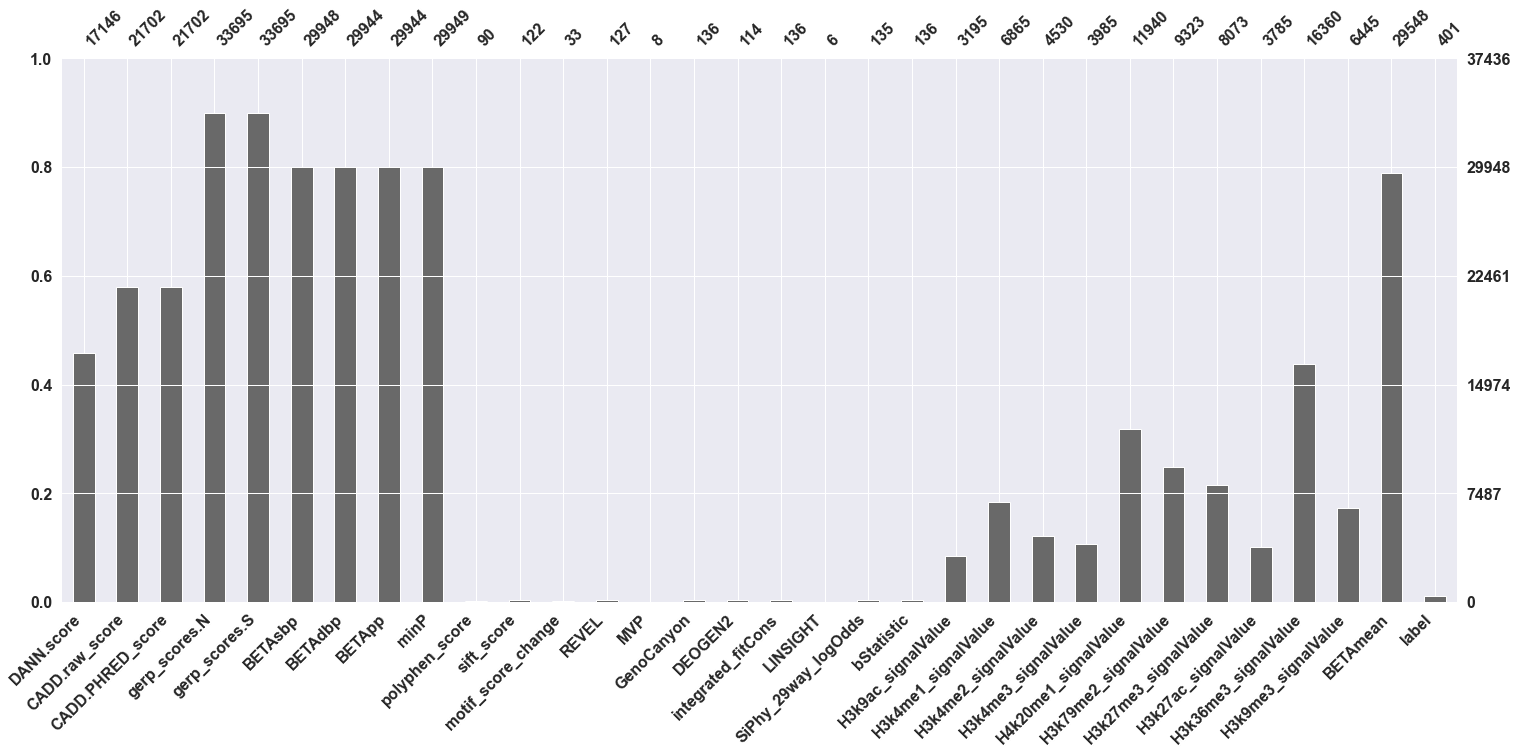

In [11]:
sns.set_style("darkgrid")
msno.bar(features_missing)

In [49]:
positives = pd_table.loc[pd_table["label"] == 1]
len(positives)

401

# Visualising relationships between positive and 'negative' variants for each annotation

In [7]:
positives = pd_table.loc[pd_table["label"] == 1]
negatives = pd_table.loc[pd_table["label"] == 0]
# Sampling any group of negatives in equal quantity to positive variants - as this is what happens with each ML iteration
negatives = negatives.iloc[
    0:401,
]
pos_neg_dt = positives.append(negatives)

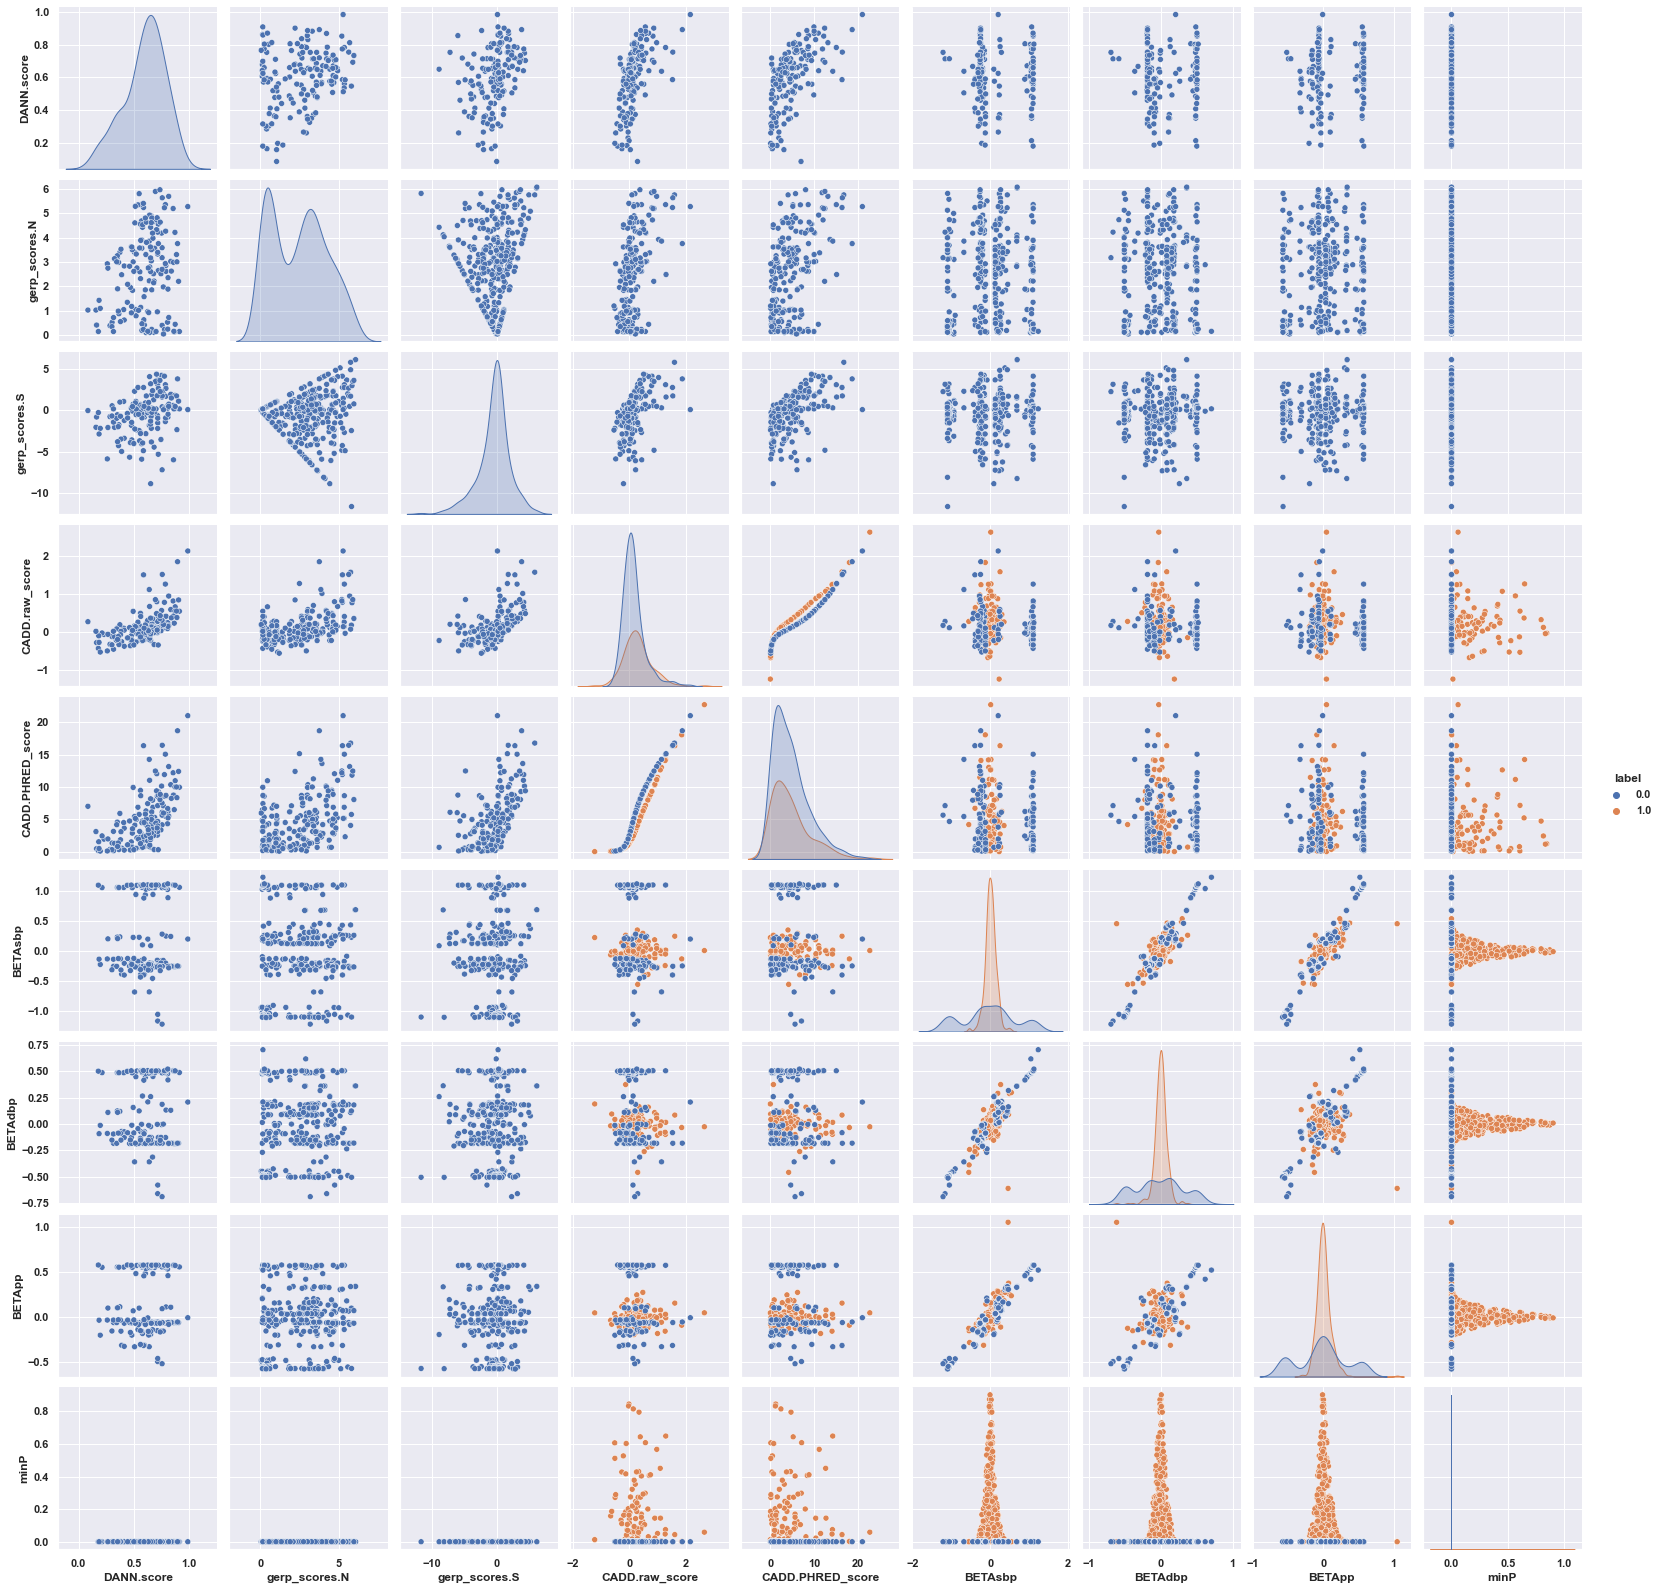

In [9]:
sns.set(font_scale=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
features2 = pos_neg_dt[
    [
        "label",
        "DANN.score",
        'gerp_scores.N',
        'gerp_scores.S',
        "CADD.raw_score",
        "CADD.PHRED_score",
        "BETAsbp",
        'BETAdbp',
        'BETApp',
        "minP",
    ]
]
sns.pairplot(features2, hue="label")

# Visualising correlated features

In [34]:
features = pd_table.drop(["CP"], axis=1)
features["label"] = np.where(pd_table["label"] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()


for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [35]:
print(correlated_features)

{'BETAmean', 'CADD.PHRED_score', 'BETApp'}


label                   1.000000
minP                    0.630982
H3k9ac_signalValue      0.125889
H3k4me3_signalValue     0.102670
polyphen_score          0.102110
H3k27me3_signalValue    0.100146
H3k27ac_signalValue     0.096514
H3k4me2_signalValue     0.094629
H4k20me1_signalValue    0.087842
H3k36me3_signalValue    0.084091
H3k4me1_signalValue     0.082146
H3k9me3_signalValue     0.082015
H3k79me2_signalValue    0.070838
CADD.raw_score          0.040000
CADD.PHRED_score        0.014362
sift_score              0.004068
BETApp                  0.001796
BETAsbp                -0.000586
BETAdbp                -0.002263
DANN.score                   NaN
gerp_scores.N                NaN
gerp_scores.S                NaN
motif_score_change           NaN
REVEL                        NaN
MVP                          NaN
GenoCanyon                   NaN
DEOGEN2                      NaN
integrated_fitCons           NaN
LINSIGHT                     NaN
SiPhy_29way_logOdds          NaN
bStatistic

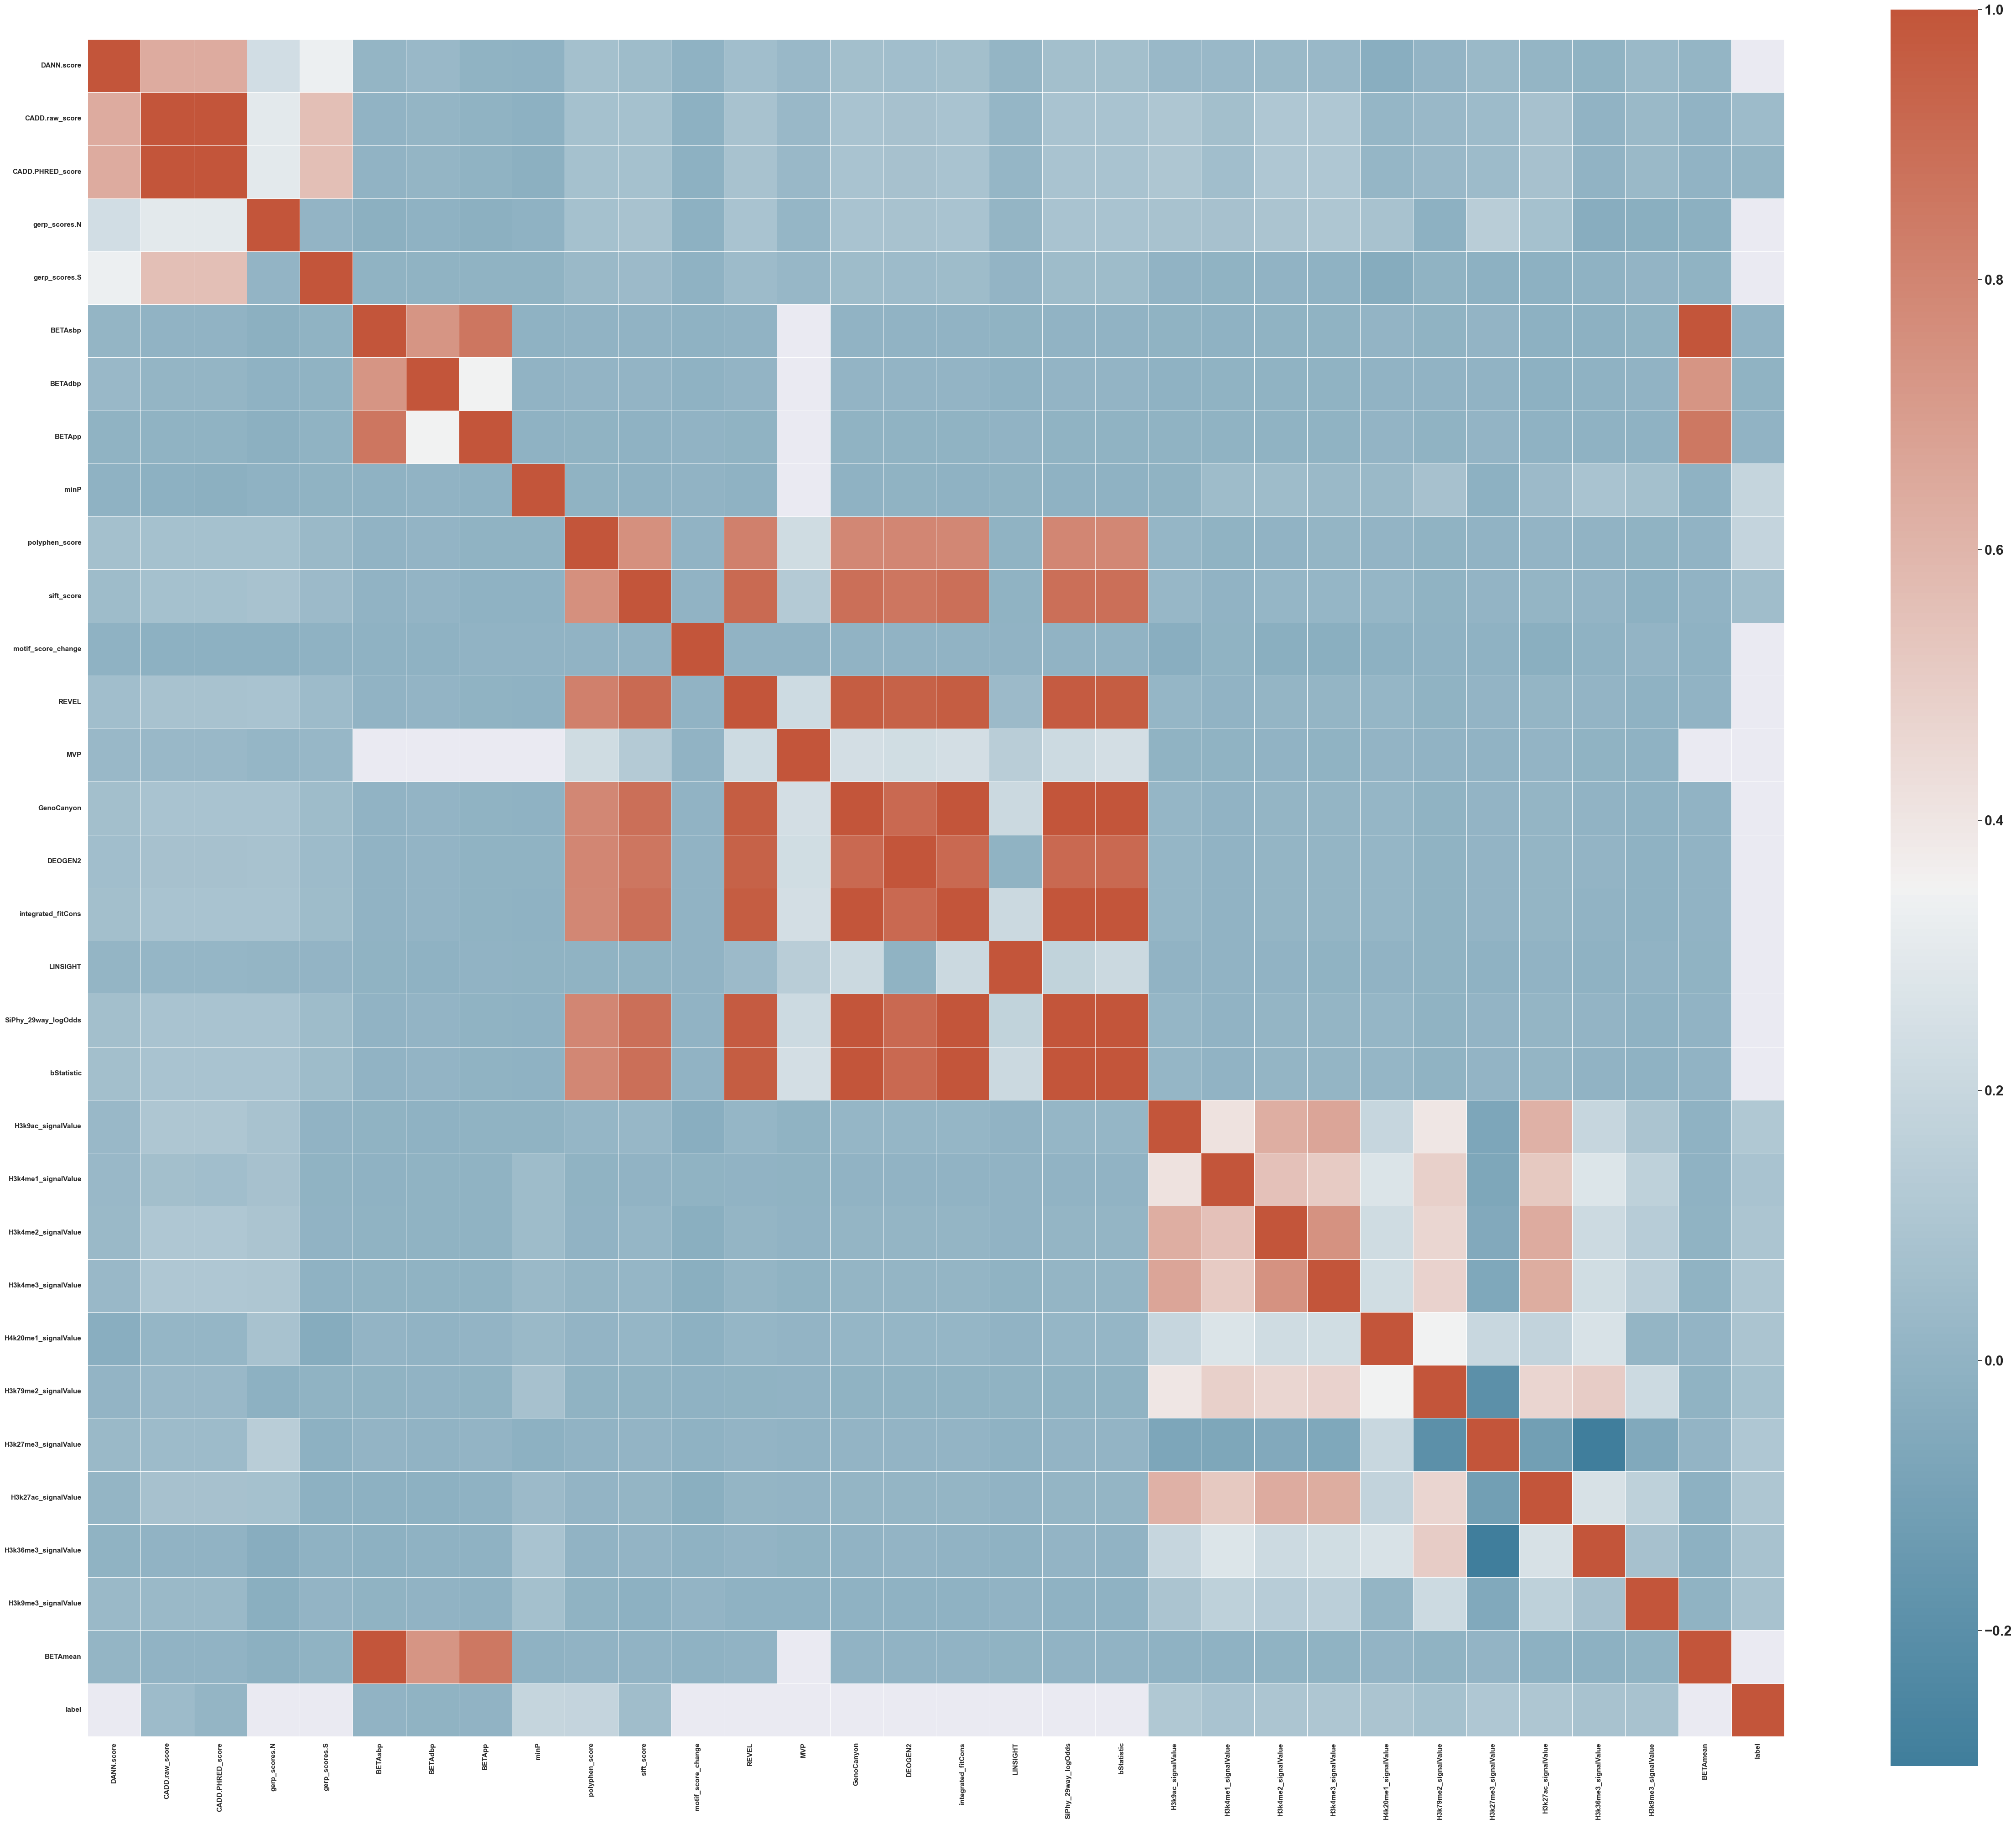

In [36]:
corr = features.corr(method="spearman")

f, ax = plt.subplots(figsize=(60, 50))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=2)
sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    ax=ax,
)

corr_matrix = features.corr()
print(corr_matrix["label"].sort_values(ascending=False))
corr = corr_matrix["label"].sort_values(ascending=False)

In [37]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(features, .8)


BETApp          BETAmean            0.823906
BETAsbp         BETApp              0.825638
CADD.raw_score  CADD.PHRED_score    0.959491
BETAsbp         BETAmean            0.999870
DANN.score      DANN.score               NaN
dtype: float64

In [39]:
features = pd_table.drop([ "CP", "label"], axis=1)
features["label"] = np.where(pd_table["label"] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()


for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [40]:
print(correlated_features)

{'BETAmean', 'CADD.PHRED_score', 'BETApp'}


In [41]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(features, .9)

CADD.raw_score  CADD.PHRED_score    0.959491
BETAsbp         BETAmean            0.999870
DANN.score      DANN.score               NaN
dtype: float64

In [42]:
corrFilter(features, .9).to_csv("all_patho_corr09_pairs.csv", header=True)

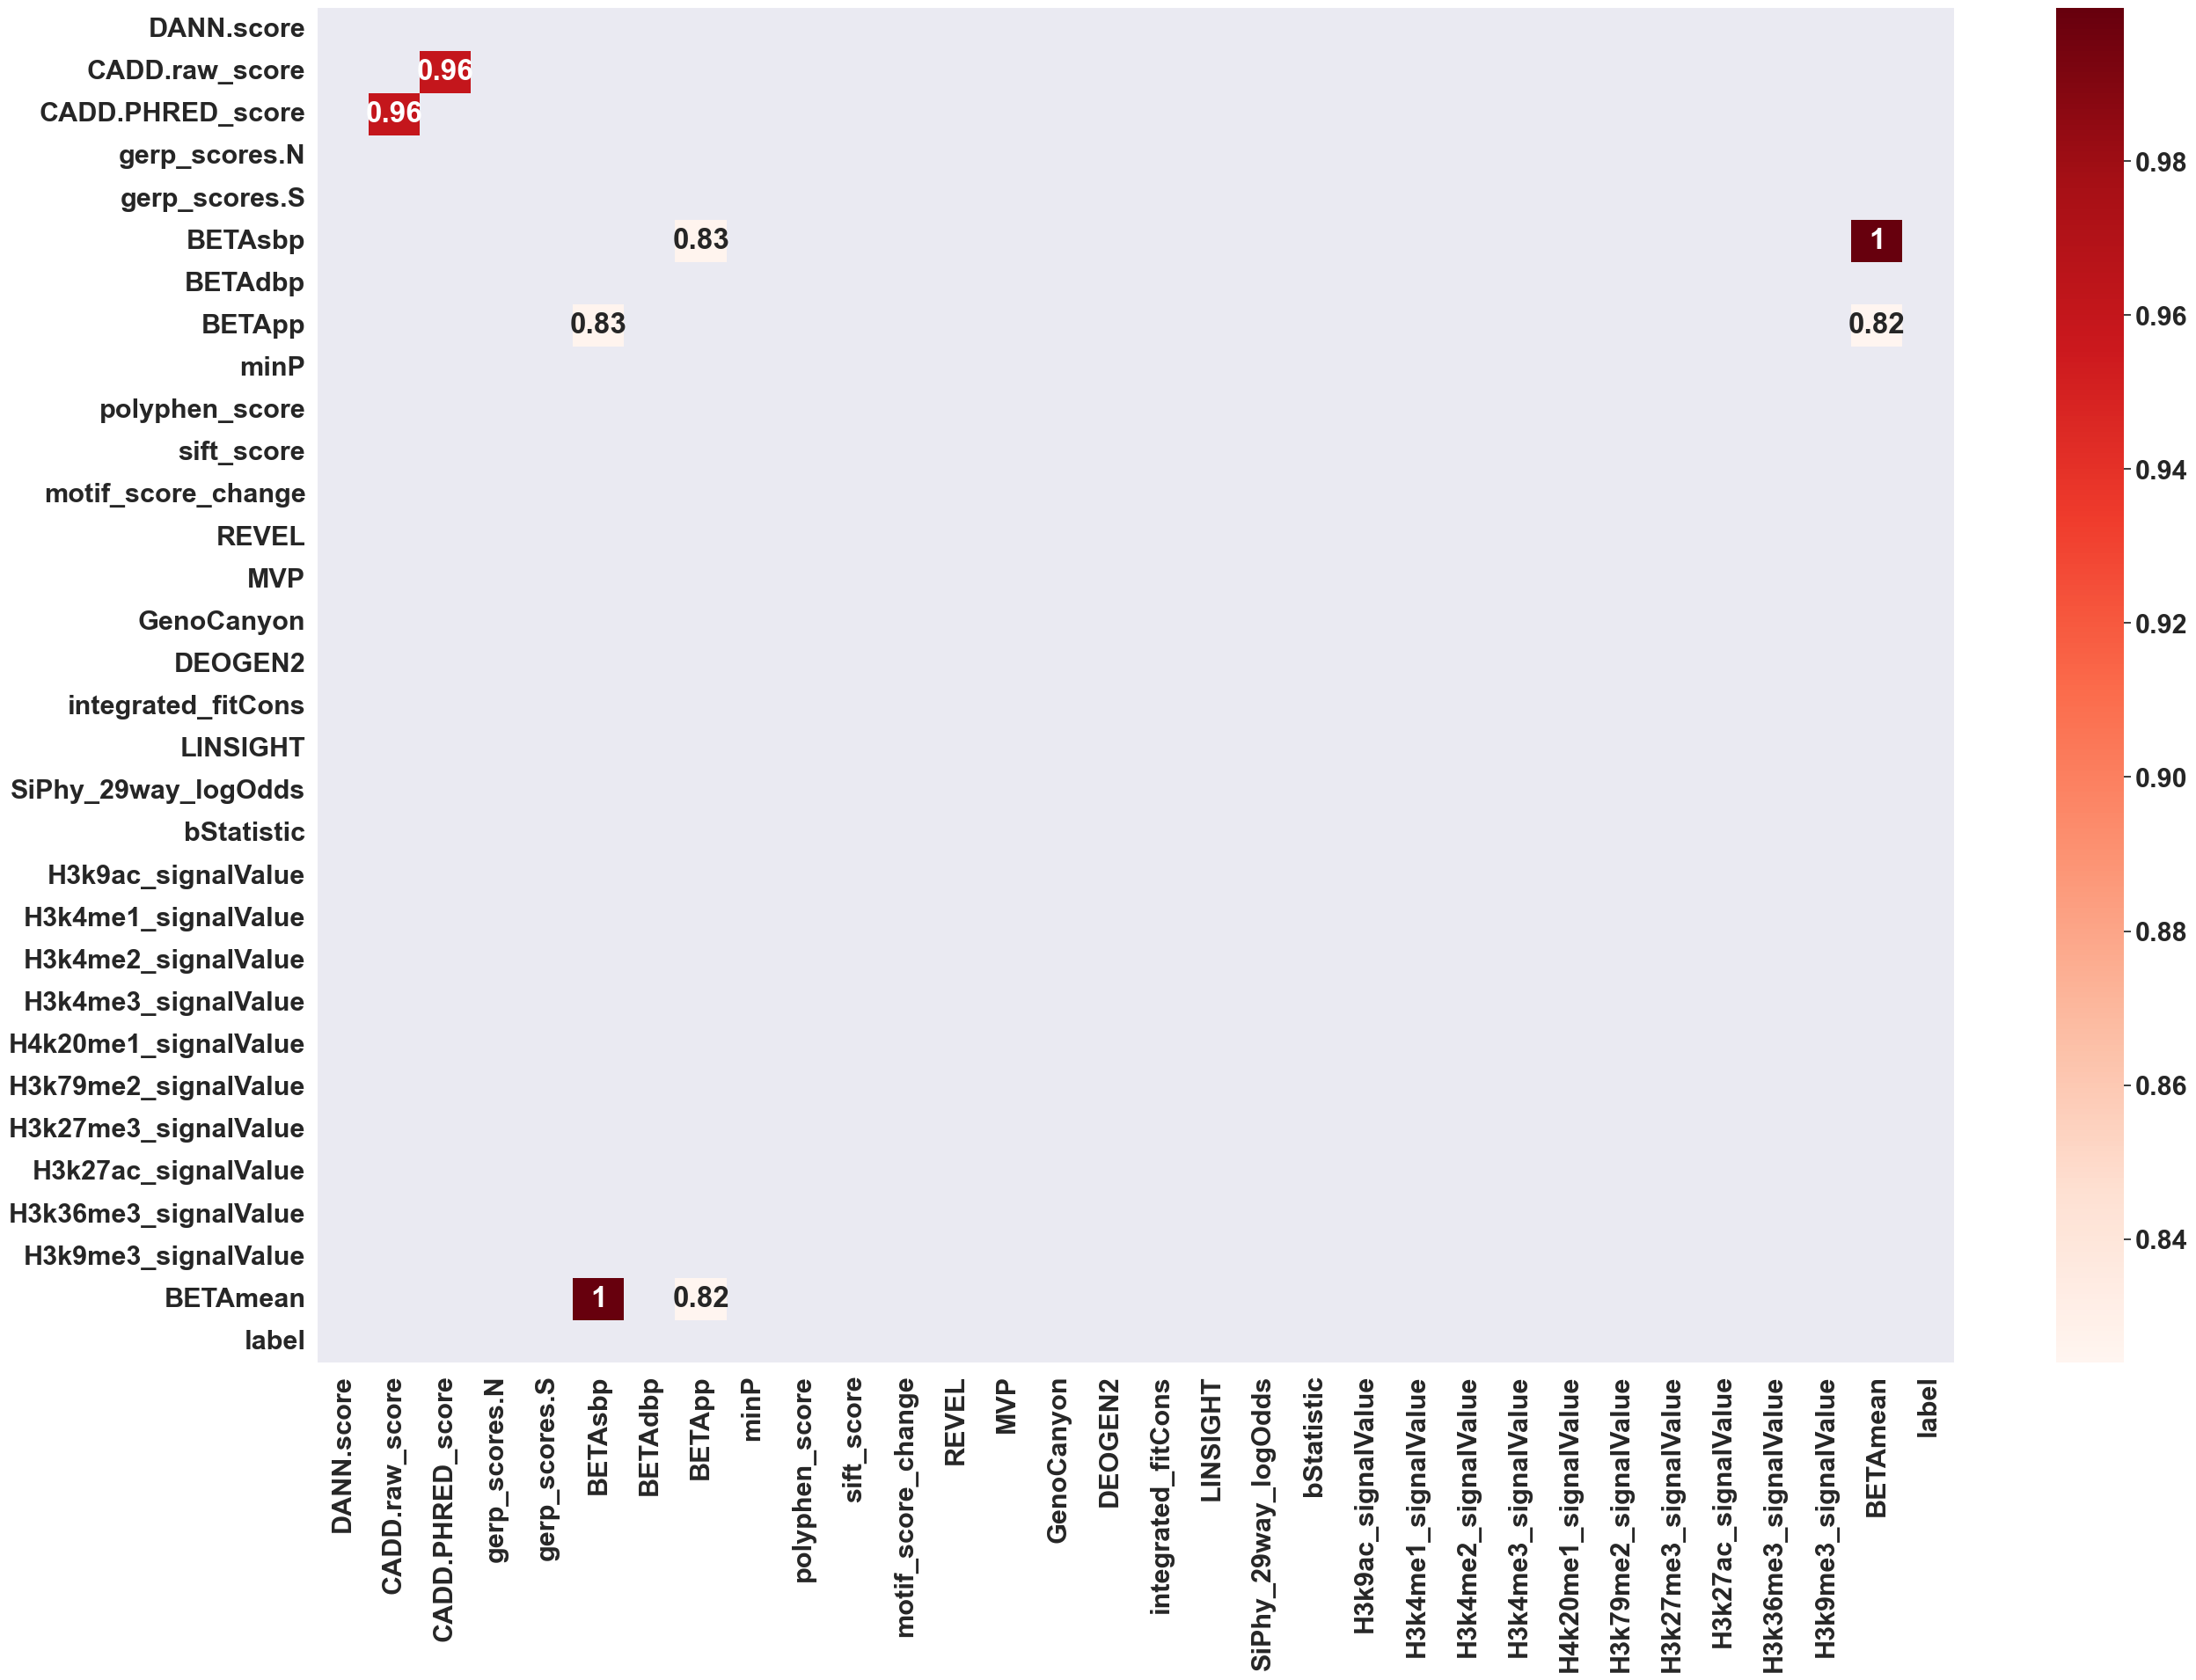

In [43]:
dfCorr = features.corr()
filteredDf = dfCorr[((dfCorr >= .8) | (dfCorr <= -.8)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,20))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()